# Load ads

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

# from housing_crawler.utils import save_file, get_file, get_grid_polygons_all_cities
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters
from housing_crawler.utils import standardize_features, return_significative_coef


from config.config import ROOT_DIR
from housing_crawler.params import dict_city_number_wggesucht

In [2]:
ads_feat_df = get_processed_ads_table()
list(ads_feat_df.columns)

===> Loaded ads_OSM.csv locally


/home/carlo/code/chvieira2/housing_crawler/housing_crawler/utils.py:35: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


['id',
 'url',
 'commercial_landlord',
 'title',
 'price_euros',
 'size_sqm',
 'available_rooms',
 'capacity',
 'available_spots_wg',
 'male_flatmates',
 'female_flatmates',
 'diverse_flatmates',
 'published_on',
 'published_at',
 'address',
 'city',
 'crawler',
 'latitude',
 'longitude',
 'available_from',
 'available_to',
 'details_searched',
 'cold_rent_euros',
 'mandatory_costs_euros',
 'extra_costs_euros',
 'transfer_costs_euros',
 'deposit',
 'zip_code',
 'home_total_size',
 'smoking',
 'wg_possible',
 'building_type',
 'building_floor',
 'furniture',
 'kitchen',
 'heating',
 'public_transport_distance',
 'parking',
 'schufa_needed',
 'type_offer_simple',
 'min_age_flatmates',
 'max_age_flatmates',
 'gender_searched',
 'min_age_searched',
 'max_age_searched',
 'construction_year',
 'energy_certificate',
 'energy_usage',
 'energy_efficiency_class',
 'heating_energy_source',
 'number_languages',
 'internet_speed',
 'toilet',
 'internet_dsl',
 'internet_wlan',
 'internet_flatrate',


In [3]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

In [4]:
# Percentage missing values per column
(ads_feat_df.isnull().sum().sort_values(ascending=False)/len(ads_feat_df)*100)[0:30]

energy_usage                      95.269729
energy_efficiency_class           94.219830
toilet                            93.643340
energy_certificate                92.295652
construction_year                 88.149506
heating_energy_source             84.675295
kitchen                           84.217157
internet_speed                    81.220173
heating                           59.699156
transfer_costs_euros              59.584622
home_total_size                   57.992593
max_age_flatmates                 57.305387
smoking                           55.591188
min_age_flatmates                 53.712824
available_to                      53.415035
activities_public_service         50.868553
social_life_community             50.868553
comfort_leisure_mass              50.868553
activities_educational            50.868553
mobility_street_secondary         50.868553
comfort_leisure_spots             50.868553
activities_education              50.868553
mobility_public_transport_bus   

# Creating WG, single-room and multi-room dataframes

In [5]:
wg_df = ads_feat_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_feat_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_feat_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

# Linear model WG

In [6]:
wg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18529 entries, 0 to 18528
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 20.2+ MB


In [7]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'cold_rent_euros'#'price_per_sqm'

selected_num_features = [
            'size_sqm',
#         'home_total_size',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',

        'days_available',
#         'sin_published_at',
#         'cos_published_at',
        'sin_day_week_int',
        'cos_day_week_int',
    
# Values
#         'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
#         'transfer_costs_euros',
#         'price_per_sqm',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
#         'min_age_flatmates',
#         'max_age_flatmates',
    
# Person searched
        'min_age_searched',
        'max_age_searched',
    
# Details
    
        'smoking_numerical',
        'furniture_numerical',
#       'kitchen_numerical',
        'public_transport_distance',

    
# WG only
        'number_languages',
        
#         'internet_speed',
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            
        'rental_length_term',
    
# Person searched
        'gender_searched',
        'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'building_type',
        'building_floor',
#         'furniture',
#         'kitchen',
#         'heating',
#         'parking',
    
        'tv_kabel',
        'tv_satellit',
    
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
#         'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = wg_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18529 entries, 0 to 18528
Data columns (total 97 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cold_rent_euros                 18529 non-null  float64
 1   size_sqm                        18529 non-null  float64
 2   capacity                        18529 non-null  float64
 3   days_available                  18529 non-null  int64  
 4   sin_day_week_int                18529 non-null  float64
 5   cos_day_week_int                18529 non-null  float64
 6   male_flatmates                  18529 non-null  float64
 7   female_flatmates                18529 non-null  int64  
 8   diverse_flatmates               18529 non-null  float64
 9   min_age_searched                15840 non-null  float64
 10  max_age_searched                15840 non-null  float64
 11  smoking_numerical               15840 non-null  float64
 12  furniture_numerical             

In [8]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Berlin']
df_city.shape

(5493, 97)

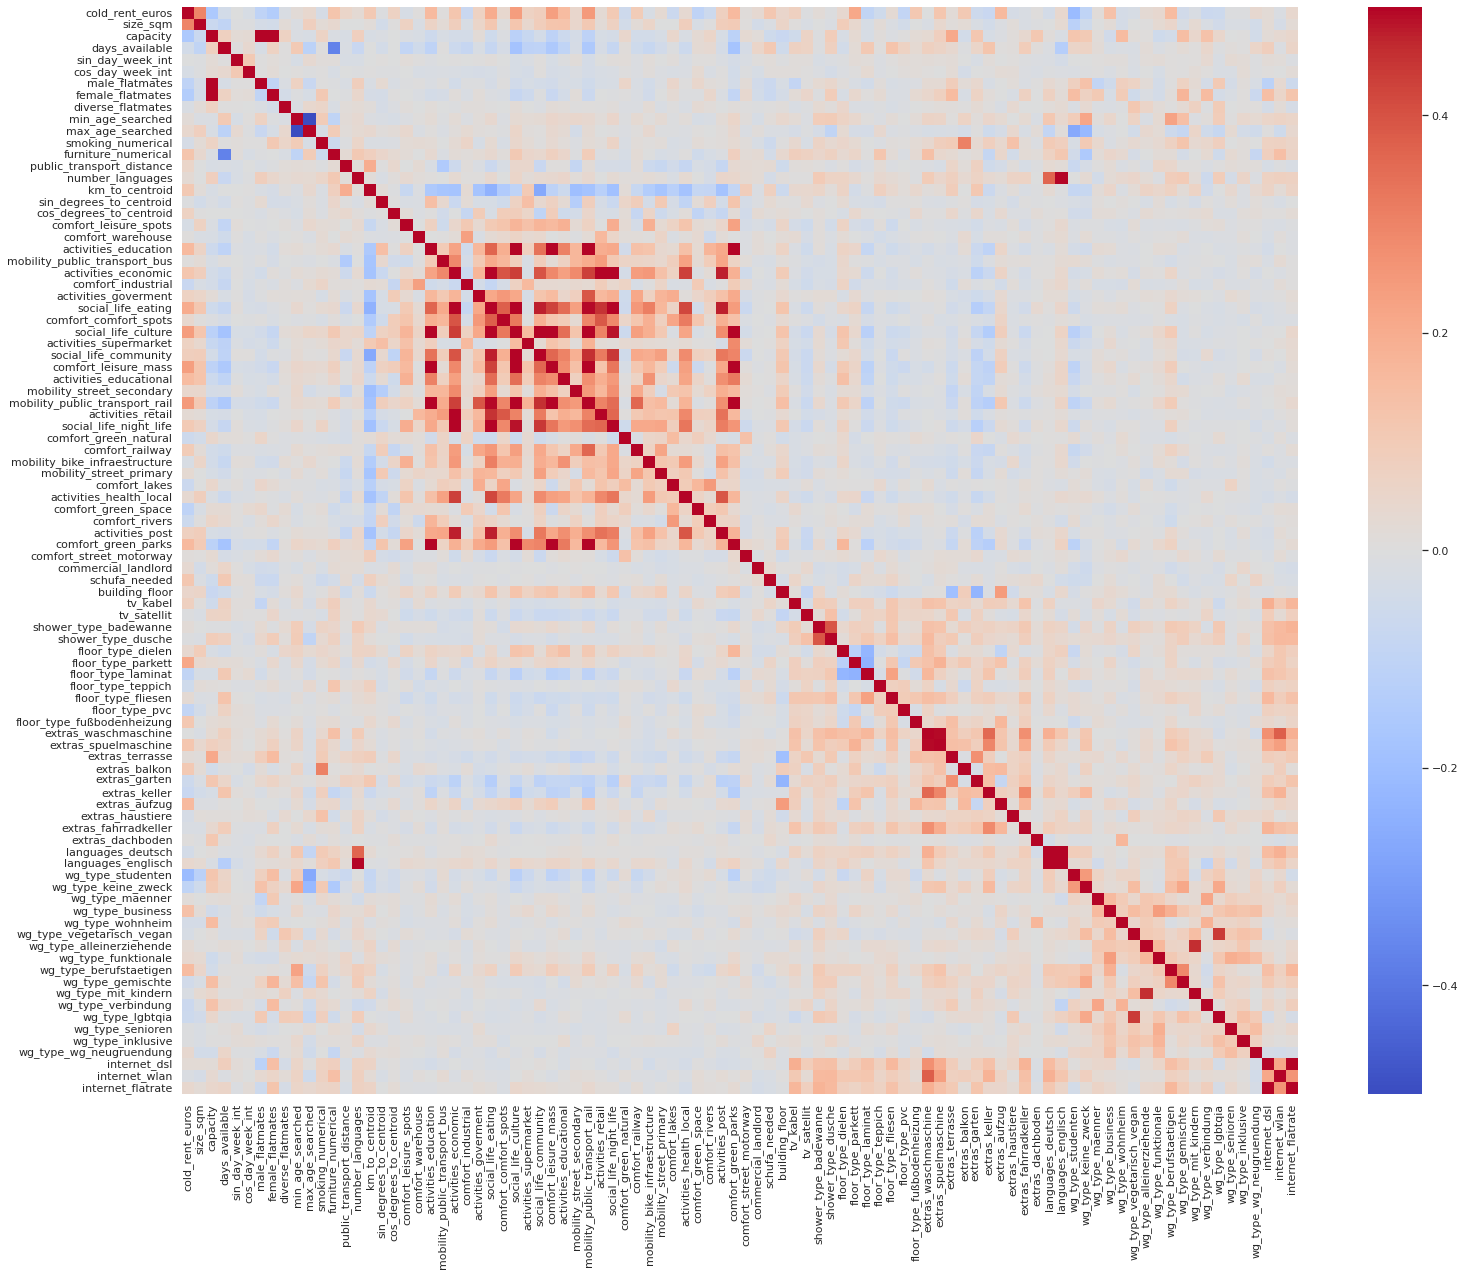

In [9]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 20))

data_corr = df_city.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [10]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
3063,mobility_public_transport_rail,social_life_culture,0.754571
2517,social_life_culture,mobility_public_transport_rail,0.754571
2322,social_life_eating,activities_economic,0.733198
2049,activities_economic,social_life_eating,0.733198
2787,comfort_leisure_mass,social_life_culture,0.689402
2514,social_life_culture,comfort_leisure_mass,0.689402
2335,social_life_eating,social_life_night_life,0.666643
3245,social_life_night_life,social_life_eating,0.666643
3066,mobility_public_transport_rail,comfort_leisure_mass,0.665563
2793,comfort_leisure_mass,mobility_public_transport_rail,0.665563


In [11]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
32,mobility_public_transport_rail,4.48
26,social_life_culture,3.83
1,capacity,3.64
24,social_life_eating,3.58
21,activities_economic,2.99
29,comfort_leisure_mass,2.72
6,female_flatmates,2.69
8,min_age_searched,2.58
9,max_age_searched,2.55
44,comfort_green_parks,2.39


In [12]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        cold_rent_euros   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     40.43
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:06:35   Log-Likelihood:                -33341.
No. Observations:                5493   AIC:                         6.699e+04
Df Residuals:                    5341   BIC:                         6.799e+04
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        343.7251     51.200      6.713      0.000     243.352     444.098
C(city)[Berlin]                        481.8088     50.414      9.557      0.000     382.977     580.641
C(city)[Bonn]                          399.0264     51.091      7.810      0.000     298.866     499.186
C(city)[Bremen]                        374.3078     50.921      7.351      0.000     274.482     474.134
C(city)[Darmstadt]                     385.2628     51.176      7.528      0.000     284.938     485.588
C(city)[Dresden]                       290.4131     50.934      5.702      0.000     190.561     390.265
C(city)[Frankfurt am Main]             476.2317     50.595      9.413      0.000     377.045     575.419
C(city)[Göttingen]                     342.5638     50.940      6.725      0.000     242.700     442.428
C(city)[Hamburg]                       488.4296     50.432      9.685      0.000     389.563     587.296
C(city)[Hannover]                      353.5788     50.882      6.949      0.000     253.829     453.328
C(city)[Heidelberg]                    413.0810     51.121      8.081      0.000     312.864     513.298
C(city)[Karlsruhe]                     369.1007     50.786      7.268      0.000     269.539     468.663
C(city)[Kiel]                          331.8656     51.476      6.447      0.000     230.952     432.779
C(city)[Köln]                          445.1766     50.406      8.832      0.000     346.361     543.992
C(city)[Leipzig]                       287.9598     50.383      5.715      0.000     189.189     386.730
C(city)[Mainz]                         392.6348     51.271      7.658      0.000     292.123     493.147
C(city)[Mannheim]                      363.6367     51.575      7.051      0.000     262.528     464.746
C(city)[München]                       598.5773     50.390     11.879      0.000     499.793     697.361
C(city)[Münster]                       350.7242     51.049      6.870      0.000     250.647     450.801
C(city)[Nürnberg]                      364.4496     51.461      7.082      0.000     263.566     465.334
C(city)[Regensburg]                    355.3431     51.362      6.918      0.000     254.653     456.033
C(city)[Stuttgart]                     454.7393     50.379      9.026      0.000     355.977     553.502
C(city)[Tübingen]                      405.6654     52.389      7.743      0.000     302.962     508.369
C(city)[Würzburg]                      358.4994     51.333      6.984      0.000     257.867     459.132
C(commercial_landlord)[T.1.0]           43.2568     18.790      2.302      0.021       6.420      80.094
C(rental_length_term)[T.270days]         8.4378      7.287      1.158      0.247      -5.848      22.724
C(rental_length_term)[T.365days]      

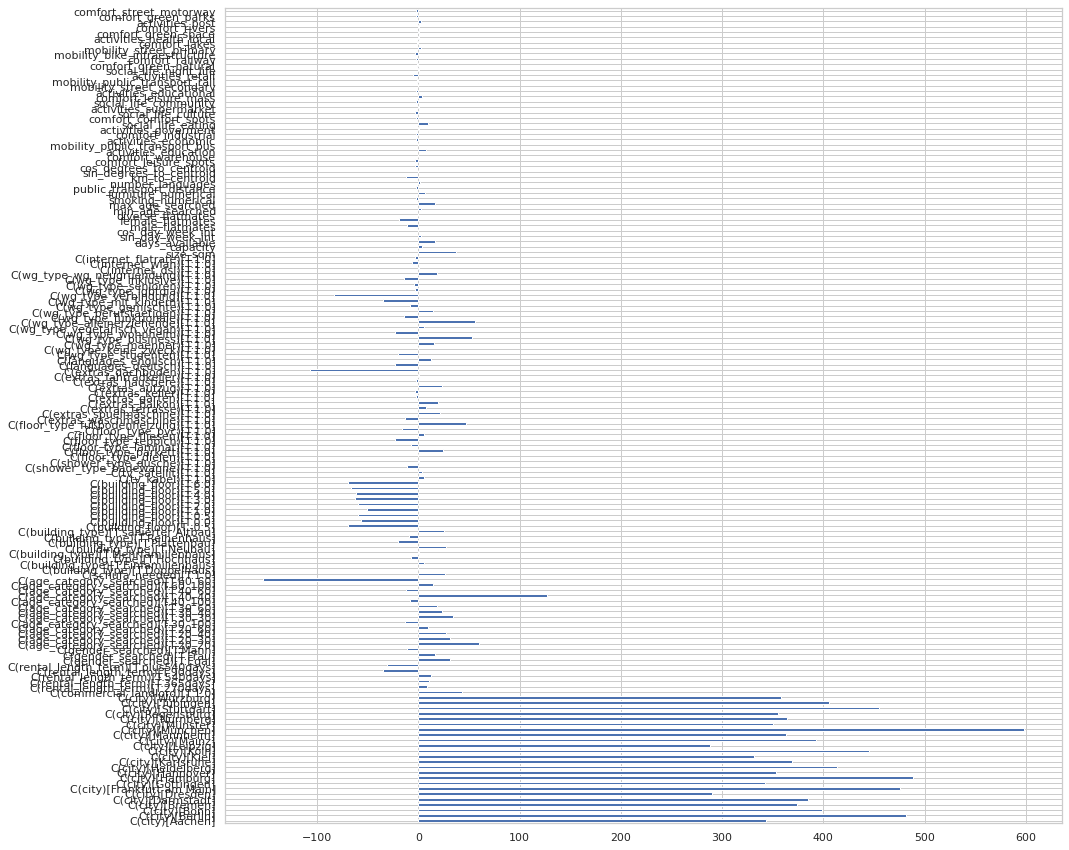

In [13]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 104.66347914778841
RMSE base model: 153.21785457294612


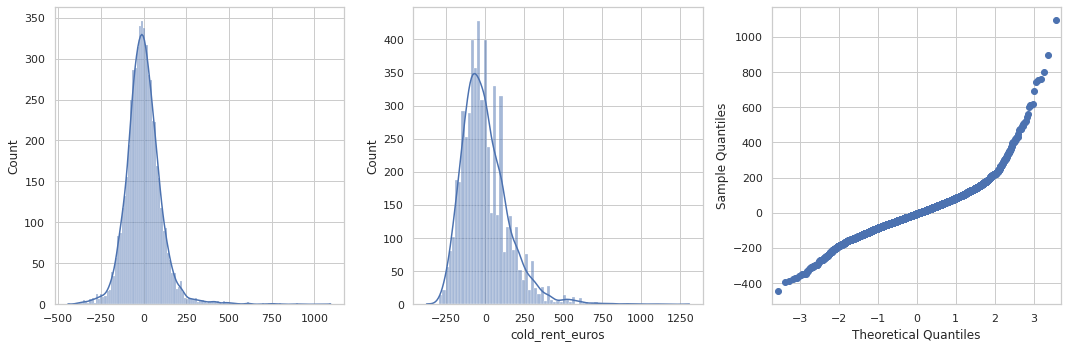

In [14]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['cold_rent_euros'])]*len(y_pred)
y_true = df_city['cold_rent_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_true - y_pred
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

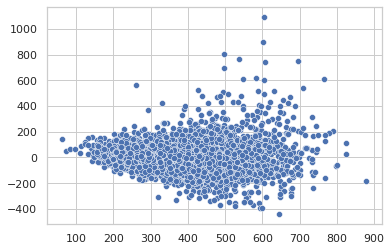

In [15]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                            p_value        coef
variable                                                       
C(city)[München]                       3.853666e-32  598.577265
C(city)[Hamburg]                       5.292362e-22  488.429569
C(city)[Berlin]                        1.797713e-21  481.808794
C(city)[Frankfurt am Main]             7.017521e-21  476.231677
C(city)[Stuttgart]                     2.430192e-19  454.739270
C(city)[Köln]                          1.374756e-18  445.176590
C(city)[Heidelberg]                    7.908392e-16  413.081030
C(city)[Tübingen]                      1.150698e-14  405.665375
C(city)[Bonn]                          6.834006e-15  399.026373
C(city)[Mainz]                         2.227053e-14  392.634817
C(city)[Darmstadt]                     6.001719e-14  385.262798
C(city)[Bremen]                        2.268563e-13  374.307794
C(city)[Karlsruhe]                     4.182922e-13  369.100716
C(city)[Nürnberg]                      1

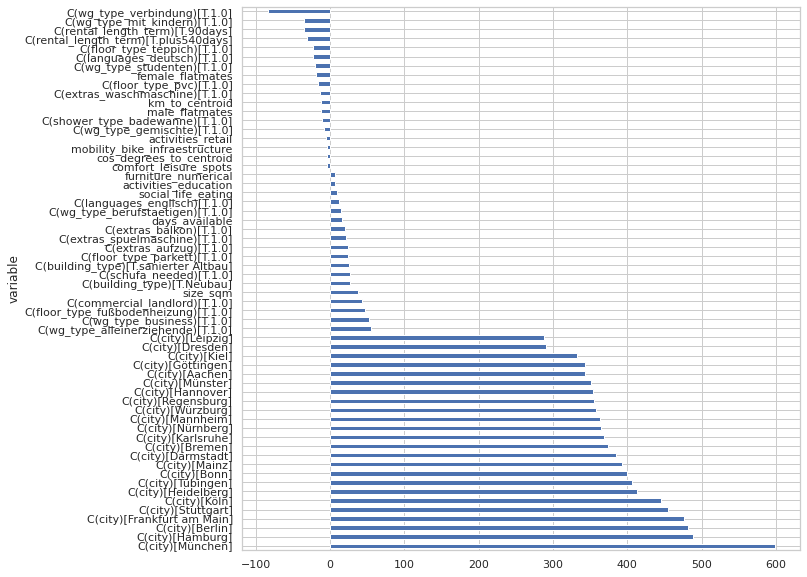

In [16]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Apartment

In [17]:
flathouse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4127 entries, 0 to 4126
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 4.5+ MB


In [18]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'cold_rent_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
            'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

#             'building_floor',
#             'public_transport_distance',
#             'home_total_size',
            'furniture_numerical',
            'kitchen_numerical',
            'smoking_numerical',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
            'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
#             'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = flathouse_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4127 entries, 0 to 4126
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cold_rent_euros                 4127 non-null   float64
 1   size_sqm                        4127 non-null   float64
 2   available_rooms                 4127 non-null   float64
 3   transfer_costs_euros            1658 non-null   float64
 4   furniture_numerical             3616 non-null   float64
 5   kitchen_numerical               3616 non-null   float64
 6   smoking_numerical               3616 non-null   float64
 7   km_to_centroid                  2021 non-null   float64
 8   sin_degrees_to_centroid         2021 non-null   float64
 9   cos_degrees_to_centroid         2021 non-null   float64
 10  comfort_leisure_spots           2021 non-null   float64
 11  comfort_warehouse               2021 non-null   float64
 12  activities_education            20

In [19]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(704, 57)

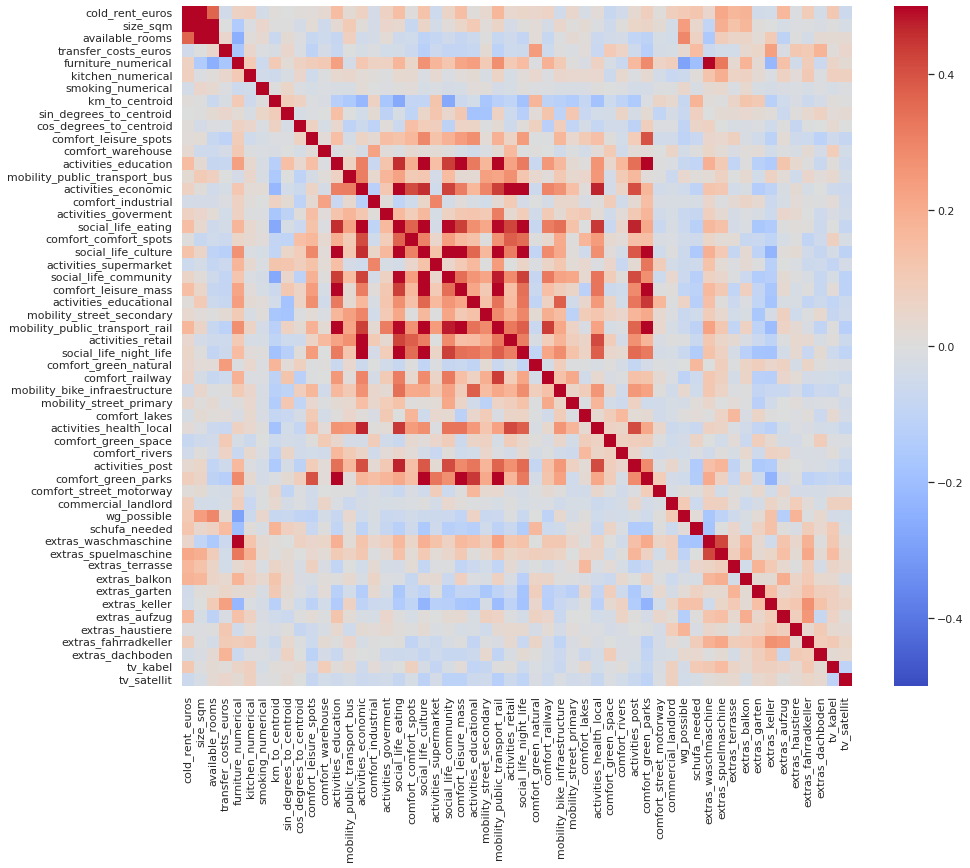

In [20]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [21]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
1369,mobility_public_transport_rail,social_life_culture,0.734849
1051,social_life_culture,mobility_public_transport_rail,0.734849
773,activities_economic,social_life_eating,0.733046
932,social_life_eating,activities_economic,0.733046
56,size_sqm,available_rooms,0.717558
109,available_rooms,size_sqm,0.717558
1362,mobility_public_transport_rail,activities_education,0.663784
673,activities_education,mobility_public_transport_rail,0.663784
1475,social_life_night_life,social_life_eating,0.663642
945,social_life_eating,social_life_night_life,0.663642


In [22]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
24,mobility_public_transport_rail,4.69
18,social_life_culture,3.97
16,social_life_eating,3.69
13,activities_economic,3.41
36,comfort_green_parks,3.02
21,comfort_leisure_mass,2.72
11,activities_education,2.68
26,social_life_night_life,2.48
1,available_rooms,2.38
0,size_sqm,2.35


In [23]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        cold_rent_euros   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     8.726
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           8.75e-65
Time:                        11:06:40   Log-Likelihood:                -4876.9
No. Observations:                 704   AIC:                             9934.
Df Residuals:                     614   BIC:                         1.034e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        628.6548     82.211      7.647      0.000     467.206     790.103
C(city)[Berlin]                        886.9271     58.076     15.272      0.000     772.875    1000.979
C(city)[Bonn]                          724.3875     97.201      7.452      0.000     533.501     915.274
C(city)[Bremen]                        563.7466    123.228      4.575      0.000     321.748     805.745
C(city)[Darmstadt]                     948.6714    127.977      7.413      0.000     697.346    1199.997
C(city)[Dresden]                       587.6700     89.549      6.563      0.000     411.810     763.530
C(city)[Frankfurt am Main]             930.0950     72.720     12.790      0.000     787.286    1072.904
C(city)[Göttingen]                     626.2888    101.554      6.167      0.000     426.854     825.724
C(city)[Hamburg]                      1038.5534     60.318     17.218      0.000     920.099    1157.008
C(city)[Hannover]                      737.7778     89.986      8.199      0.000     561.060     914.496
C(city)[Heidelberg]                    722.8289    119.362      6.056      0.000     488.421     957.237
C(city)[Karlsruhe]                     732.4345     98.472      7.438      0.000     539.052     925.817
C(city)[Kiel]                          724.5511    121.552      5.961      0.000     485.844     963.259
C(city)[Köln]                          879.3058     66.774     13.168      0.000     748.173    1010.438
C(city)[Leipzig]                       660.1292     77.124      8.559      0.000     508.669     811.589
C(city)[Mainz]                         766.2648     98.934      7.745      0.000     571.975     960.554
C(city)[Mannheim]                      738.7595     87.892      8.405      0.000     566.153     911.366
C(city)[München]                      1115.9227     65.062     17.152      0.000     988.152    1243.693
C(city)[Münster]                       521.5073    114.360      4.560      0.000     296.923     746.092
C(city)[Nürnberg]                      668.7638     88.693      7.540      0.000     494.586     842.941
C(city)[Regensburg]                    767.3966    107.253      7.155      0.000     556.769     978.024
C(city)[Stuttgart]                     911.4194     71.346     12.775      0.000     771.308    1051.531
C(city)[Tübingen]                      853.7330    152.166      5.611      0.000     554.903    1152.563
C(city)[Würzburg]                      773.7768    108.488      7.132      0.000     560.724     986.829
C(commercial_landlord)[T.1.0]          273.0674    102.622      2.661      0.008      71.535     474.600
C(rental_length_term)[T.270days]       -40.2404     55.197     -0.729      0.466    -148.637      68.157
C(rental_length_term)[T.365days]      

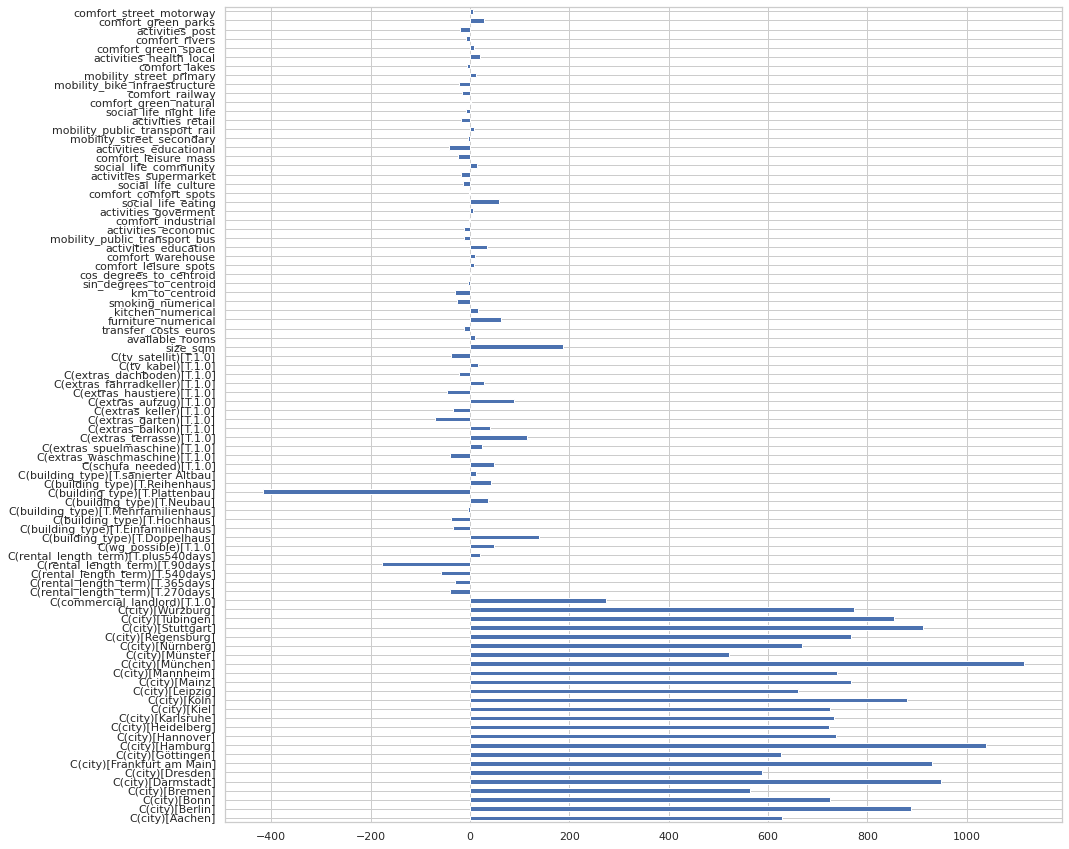

In [24]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 246.7653944468543
RMSE base model: 371.37298038281705


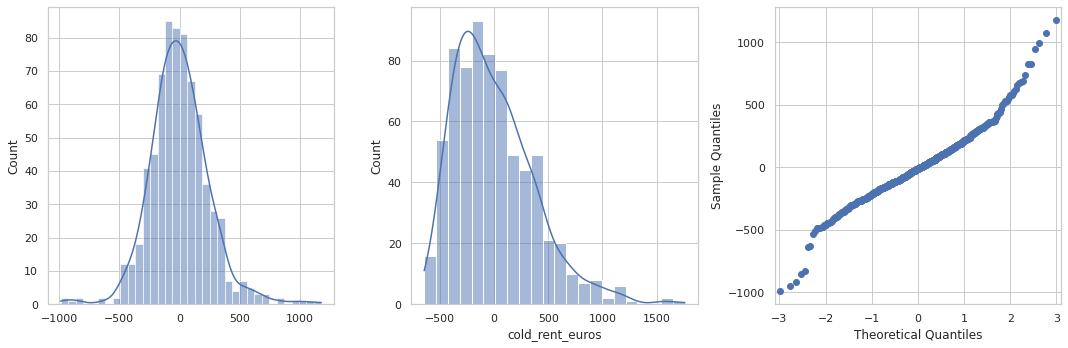

In [25]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['cold_rent_euros'])]*len(y_pred)
y_true = df_city['cold_rent_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_true - y_pred
residuals_base = y_true - y_base

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)

plt.tight_layout()
fig.show();

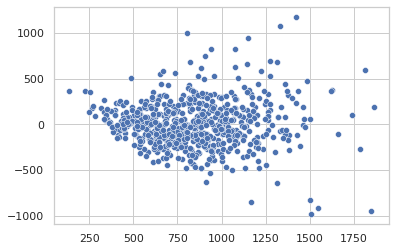

In [26]:
sns.scatterplot(x=y_pred, y=residuals);

                                      p_value         coef
variable                                                  
C(city)[München]                 3.627664e-54  1115.922713
C(city)[Hamburg]                 1.678291e-54  1038.553443
C(city)[Darmstadt]               4.117691e-13   948.671423
C(city)[Frankfurt am Main]       2.244475e-33   930.095016
C(city)[Stuttgart]               2.627833e-33   911.419381
C(city)[Berlin]                  7.201245e-45   886.927055
C(city)[Köln]                    4.657302e-35   879.305774
C(city)[Tübingen]                3.054239e-08   853.732963
C(city)[Würzburg]                2.786331e-12   773.776757
C(city)[Regensburg]              2.393410e-12   767.396619
C(city)[Mainz]                   3.956991e-14   766.264816
C(city)[Mannheim]                2.978640e-16   738.759550
C(city)[Hannover]                1.421631e-15   737.777775
C(city)[Karlsruhe]               3.458571e-13   732.434487
C(city)[Kiel]                    4.232685e-09   724.5511

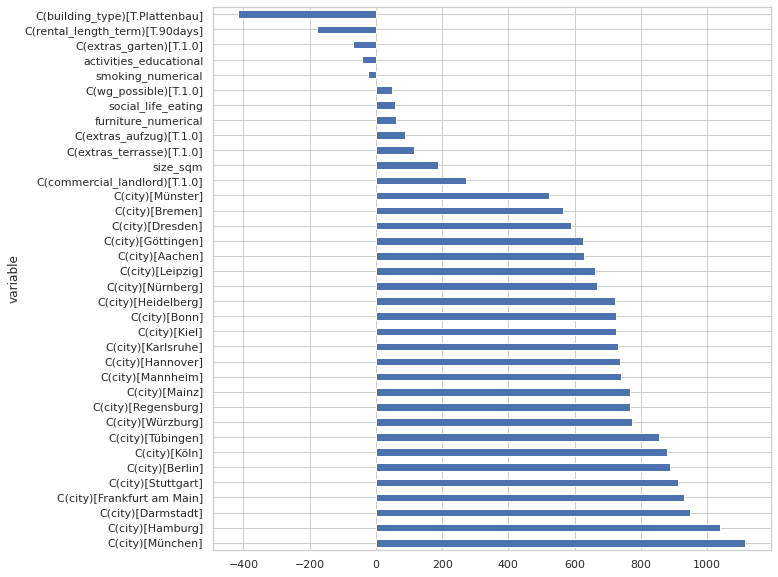

In [27]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Single-room flats

In [28]:
singleroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 3.9+ MB


In [29]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'cold_rent_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
#             'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

            'building_floor',
#             'public_transport_distance',
#             'home_total_size',
            'furniture_numerical',
            'kitchen_numerical',
#             'smoking_numerical',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
            'gender_searched',
                         
            'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = singleroom_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cold_rent_euros                 3537 non-null   float64
 1   size_sqm                        3537 non-null   float64
 2   transfer_costs_euros            1422 non-null   float64
 3   building_floor                  2607 non-null   float64
 4   furniture_numerical             2933 non-null   float64
 5   kitchen_numerical               2933 non-null   float64
 6   km_to_centroid                  1796 non-null   float64
 7   sin_degrees_to_centroid         1796 non-null   float64
 8   cos_degrees_to_centroid         1796 non-null   float64
 9   comfort_leisure_spots           1796 non-null   float64
 10  comfort_warehouse               1796 non-null   float64
 11  activities_education            1796 non-null   float64
 12  mobility_public_transport_bus   17

In [30]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(533, 57)

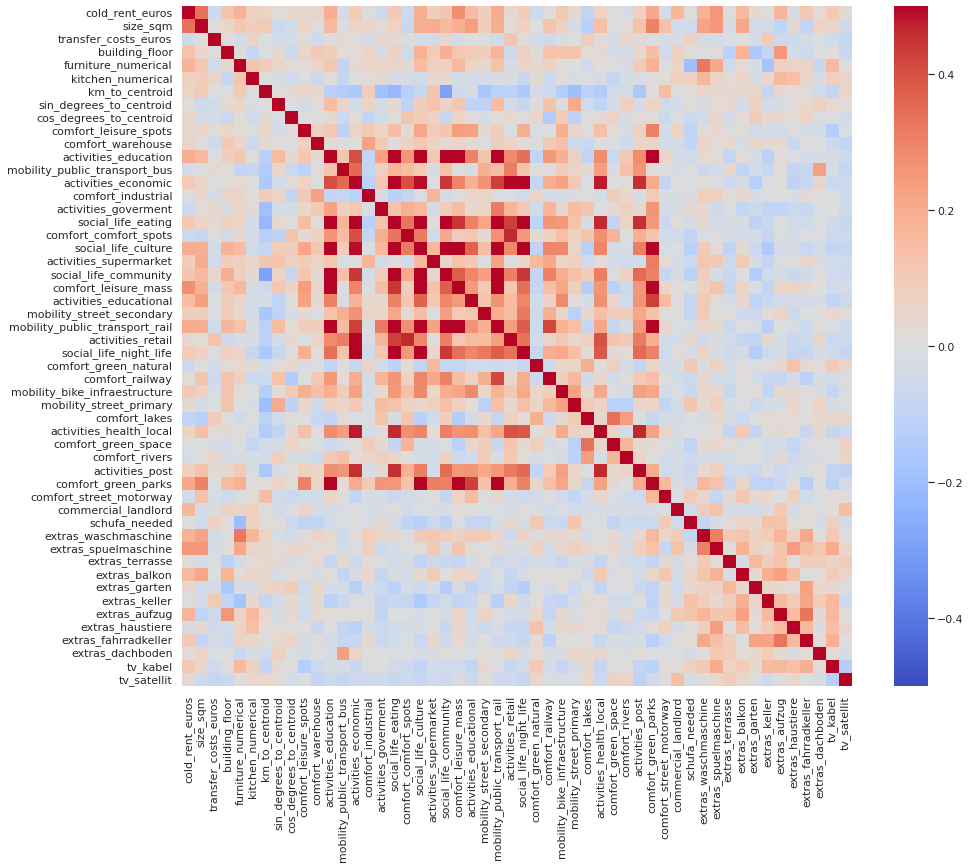

In [31]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [32]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
1266,mobility_public_transport_rail,social_life_culture,0.813495
960,social_life_culture,mobility_public_transport_rail,0.813495
1259,mobility_public_transport_rail,activities_education,0.784526
596,activities_education,mobility_public_transport_rail,0.784526
947,social_life_culture,activities_education,0.759928
590,activities_education,social_life_culture,0.759928
1110,comfort_leisure_mass,social_life_culture,0.726357
957,social_life_culture,comfort_leisure_mass,0.726357
1103,comfort_leisure_mass,activities_education,0.718905
593,activities_education,comfort_leisure_mass,0.718905


In [33]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
17,social_life_culture,6.51
23,mobility_public_transport_rail,5.72
10,activities_education,4.51
15,social_life_eating,3.93
35,comfort_green_parks,3.68
20,comfort_leisure_mass,3.26
12,activities_economic,2.84
25,social_life_night_life,2.68
19,social_life_community,2.23
24,activities_retail,1.96


In [34]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        cold_rent_euros   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     5.063
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           1.62e-30
Time:                        11:06:44   Log-Likelihood:                -3441.7
No. Observations:                 533   AIC:                             7059.
Df Residuals:                     445   BIC:                             7436.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        295.1692     57.005      5.178      0.000     183.136     407.202
C(city)[Berlin]                        569.0127     46.319     12.285      0.000     477.982     660.043
C(city)[Bonn]                          362.0679     85.125      4.253      0.000     194.770     529.365
C(city)[Bremen]                        446.2653     81.555      5.472      0.000     285.985     606.545
C(city)[Darmstadt]                     408.5360     95.337      4.285      0.000     221.170     595.902
C(city)[Dresden]                       387.6317     75.119      5.160      0.000     239.999     535.264
C(city)[Frankfurt am Main]             613.1029     49.320     12.431      0.000     516.175     710.031
C(city)[Göttingen]                     419.9284     79.855      5.259      0.000     262.989     576.868
C(city)[Hamburg]                       639.9001     53.363     11.991      0.000     535.025     744.776
C(city)[Hannover]                      355.7143     66.153      5.377      0.000     225.702     485.726
C(city)[Heidelberg]                    517.2983     65.506      7.897      0.000     388.558     646.038
C(city)[Karlsruhe]                     425.5752     71.206      5.977      0.000     285.634     565.517
C(city)[Kiel]                          517.4575    109.089      4.743      0.000     303.064     731.851
C(city)[Köln]                          513.3005     49.951     10.276      0.000     415.131     611.470
C(city)[Leipzig]                       348.4656     68.196      5.110      0.000     214.440     482.491
C(city)[Mainz]                         434.7640     65.458      6.642      0.000     306.119     563.409
C(city)[Mannheim]                      387.7862     62.755      6.179      0.000     264.454     511.118
C(city)[München]                       713.8295     48.301     14.779      0.000     618.903     808.756
C(city)[Münster]                       310.3433    119.682      2.593      0.010      75.131     545.555
C(city)[Nürnberg]                      427.9475     70.503      6.070      0.000     289.388     566.507
C(city)[Regensburg]                    409.7955     68.185      6.010      0.000     275.790     543.801
C(city)[Stuttgart]                     507.3237     55.484      9.144      0.000     398.281     616.366
C(city)[Tübingen]                      387.2572     85.051      4.553      0.000     220.106     554.408
C(city)[Würzburg]                      335.1986     77.045      4.351      0.000     183.781     486.616
C(commercial_landlord)[T.1.0]          218.4254     90.512      2.413      0.016      40.542     396.309
C(rental_length_term)[T.270days]       -90.3367     44.709     -2.021      0.044    -178.204      -2.469
C(rental_length_term)[T.365days]      

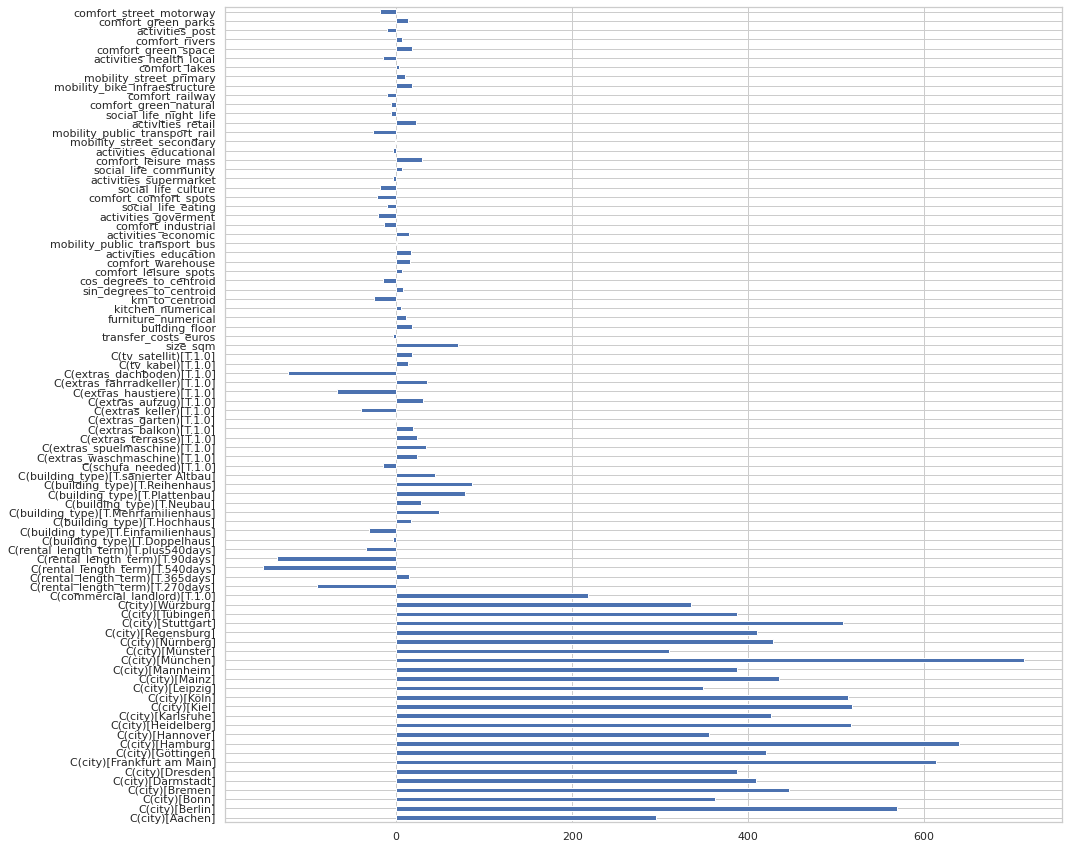

In [35]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 154.20418935520374
RMSE base model: 217.52707684303567


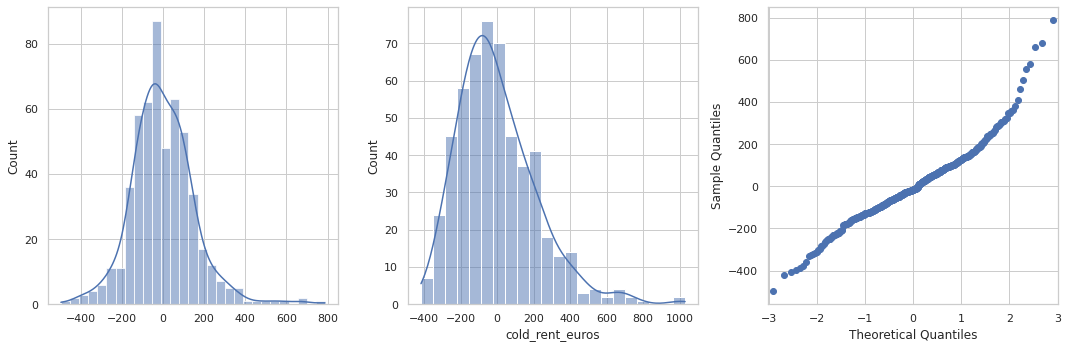

In [36]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['cold_rent_euros'])]*len(y_pred)
y_true = df_city['cold_rent_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_true - y_pred
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

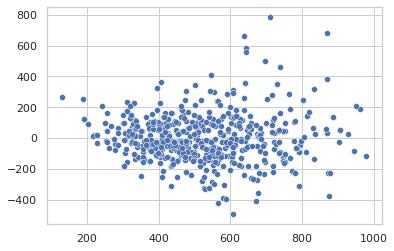

In [37]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                       p_value        coef
variable                                                  
C(city)[München]                  1.698810e-40  713.829456
C(city)[Hamburg]                  6.668938e-29  639.900131
C(city)[Frankfurt am Main]        1.162837e-30  613.102879
C(city)[Berlin]                   4.515053e-30  569.012749
C(city)[Kiel]                     2.834687e-06  517.457516
C(city)[Heidelberg]               2.253981e-14  517.298278
C(city)[Köln]                     2.272597e-22  513.300548
C(city)[Stuttgart]                2.168195e-18  507.323741
C(city)[Bremen]                   7.443106e-08  446.265301
C(city)[Mainz]                    9.055267e-11  434.763985
C(city)[Nürnberg]                 2.742381e-09  427.947527
C(city)[Karlsruhe]                4.672919e-09  425.575243
C(city)[Göttingen]                2.258635e-07  419.928441
C(city)[Regensburg]               3.865118e-09  409.795454
C(city)[Darmstadt]                2.239447e-05  408.5360

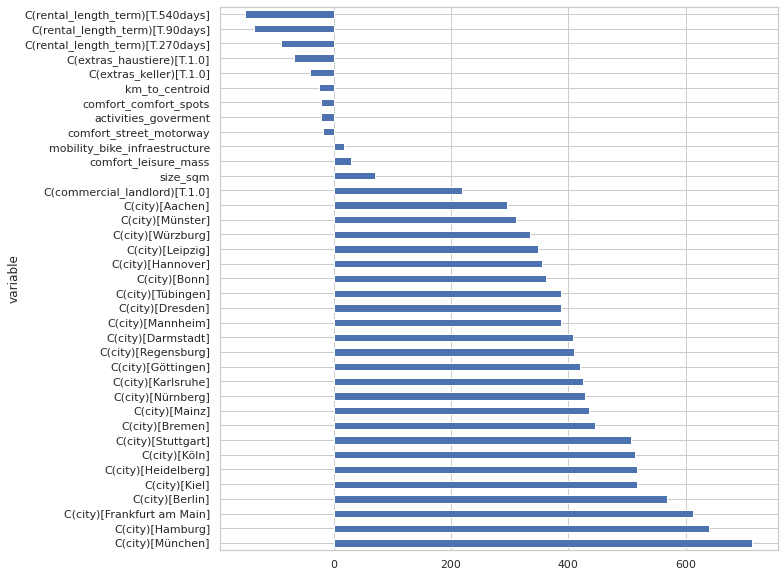

In [38]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');